So, based on previous analysis we are seeing something at 2..4 second intervals.
Now, let's repeat eveything - doing the splits, and scanning with a 2..4 sliding windows over test and control.

possible metrics:

1) directional change p>0.5 == p>0.5
2) z-score metric: (p1-0.5) (exp 0) + (p2-0.5) (exp 0)
3) moments of p (low and high) -> I would need a vector of Ps with a sliding windows for 2 (test + control) x amount of windsor splits 


In [2]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from scipy.stats import chi2, binom
import gzip
from tqdm.notebook import tqdm
import glob
import random
import seaborn as sns
from joblib import Parallel, delayed
import scipy as sp
from statsmodels.stats.proportion import proportion_confint
import scipy.stats


In [16]:
data = pd.read_parquet('data2014.parquet')

In [17]:
data_std = data.std(axis=0)[3:]

In [18]:
data -= 100

In [19]:
data.loc[:,'37'].isna().mean()

3.170979198376459e-07

In [20]:
#     if use_real_std:
#         STD_200_FLIPS = data_std
#     else:
#         STD_200_FLIPS = math.sqrt(200)/2

data.iloc[:, 3:] /= data_std

In [21]:
nans = data.iloc[3:].isna().sum(axis=1)
sqrts = np.sqrt(data.iloc[3:].shape[1]-nans)
z_norm_data = (data.iloc[3:]).sum(axis=1)/sqrts
    

In [22]:
def zscore_to_proba_vector(seq, window, mode='full'):
    return stats.chi2.sf(np.convolve(seq**2,np.ones(window),mode),window)

In [23]:
print(np.nanmean(zscore_to_proba_vector(z_norm_data,1)),
      np.nanmean(zscore_to_proba_vector(z_norm_data,2)),
      np.nanmean(zscore_to_proba_vector(z_norm_data,3)))

0.0 0.0 0.0


In [24]:
# some sanity - Z score for all data set
eggs = set(data.columns[3:])
         
data_full = data[eggs]
data_nans = data_full.isna().sum(axis=1)
sqrts = np.sqrt(data_full.shape[1]-data_nans)
z_norm_data = (data_full).sum(axis=1)/sqrts

In [25]:
def make_a_data_split(data, use_real_std=False):
    eggs = set(data.columns[3:])
         
    
    test_eggs = list(random.sample(eggs,len(eggs)//2))
    control_eggs = list(set(eggs) - set(test_eggs))

    assert set(test_eggs) - set(control_eggs) == set(test_eggs)

    test_data = data[test_eggs]
    test_nans = test_data.isna().sum(axis=1)
    sqrts = np.sqrt(test_data.shape[1]-test_nans)
    z_norm_test = (test_data).sum(axis=1)/sqrts


    control_data = data[control_eggs]
    control_nans = control_data.isna().sum(axis=1)
    sqrts = np.sqrt(control_data.shape[1]-control_nans)
    z_norm_control = (control_data).sum(axis=1)/sqrts
    
    return z_norm_test, z_norm_control, test_nans, control_nans

In [26]:
# just a test run of a split function
test, control, test_nans, control_nans = make_a_data_split(data)

In [27]:
def make_run(thr, window):
    test, control, test_nans, control_nans = make_a_data_split(data)
    test_nans = test_nans[2:-2]
    
    control_nans = control_nans[2:-2]
    test_probas = zscore_to_proba_vector(test, window, mode='same')[2:-2]

    control_probas = zscore_to_proba_vector(control, window, mode='same')[2:-2]
    random_mask_for_control = np.random.binomial(1, thr, len(control_probas)).astype(bool)
    random_mask_for_test = np.random.binomial(1, thr, len(test_probas)).astype(bool)

    return {'direct_mean': np.nanmean(control_probas[test_probas<thr]),
            'direct_counts': (test_probas<thr).sum(),
            'direct_nans': control_nans.iloc[test_probas<thr].mean(),

            'random_direct_mean': np.nanmean(control_probas[random_mask_for_control]),
            'random_direct_counts': (random_mask_for_control).sum(),
            'random_direct_nans': control_nans.iloc[random_mask_for_control].mean(),

            'inverted_mean': np.nanmean(test_probas[control_probas<thr]),
            'inverted_counts': (control_probas<thr).sum(),
            'inverted_nans': test_nans.iloc[control_probas<thr].mean(),

            'random_inverted_mean': np.nanmean(test_probas[random_mask_for_test]),
            'random_inverted_counts': (random_mask_for_test).sum(),
            'random_inverted_nans': test_nans.iloc[random_mask_for_test].mean(),

            'window': window,
            'thr': thr}
    

In [15]:
# test run for a full split analysis
make_run(0.01, 2)

{'direct_mean': 0.5002170568579719,
 'direct_counts': 316002,
 'direct_nans': 1.2291504484148834,
 'random_direct_mean': 0.5001752855765595,
 'random_direct_counts': 316229,
 'random_direct_nans': 1.227727374782199,
 'inverted_mean': 0.49947898326398327,
 'inverted_counts': 314569,
 'inverted_nans': 0.7292867383626486,
 'random_inverted_mean': 0.49975574109907056,
 'random_inverted_counts': 315786,
 'random_inverted_nans': 0.7305833697504006,
 'window': 2,
 'thr': 0.01}

In [28]:
results = []
with tqdm(total=5*1) as pbar:
    for thr in [0.5, 0.25, 0.1, 0.05, 0.01,0.0075,0.005,0.0025]:
        for window in [1]:
            partial_results = Parallel(n_jobs=2, prefer="threads")(delayed(make_run)(thr, window) for i in range(32))
            results.append(partial_results)
            pbar.update(1)

  0%|          | 0/5 [00:00<?, ?it/s]

In [31]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [40]:
results_tmp = flatten(results)

In [41]:
# add save
pd.DataFrame(results_tmp).to_pickle('results2014.pickle')

In [43]:
pd.DataFrame(results_tmp)

,direct_mean,direct_counts,direct_nans,random_direct_mean,random_direct_counts,random_direct_nans,inverted_mean,inverted_counts,inverted_nans,random_inverted_mean,random_inverted_counts,random_inverted_nans,window,thr
0,0.500022,15742194,0.935463,0.499937,15772817,0.935559,0.500156,15749858,1.021713,0.500148,15769521,1.021965,2,0.5000
1,0.499911,15744496,0.775489,0.499902,15770551,0.775490,0.499966,15750329,1.182119,0.499975,15768845,1.182100,2,0.5000
2,0.500049,15741540,0.972681,0.499962,15763970,0.972897,0.500305,15747975,0.985109,0.500128,15771515,0.984585,2,0.5000
3,0.499910,15741893,0.818034,0.499878,15771952,0.817783,0.500069,15754119,1.139335,0.500000,15768634,1.139344,2,0.5000
4,0.499978,15749593,1.018848,0.499976,15772674,1.018692,0.499947,15742804,0.938680,0.500014,15769698,0.938673,2,0.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,0.499285,79136,0.807167,0.499811,79137,0.814638,0.500270,79084,1.142911,0.500009,79026,1.147458,2,0.0025
252,0.499910,78577,0.903941,0.501351,78980,0.902760,0.497934,78892,1.059740,0.497174,78925,1.061311,2,0.0025
253,0.500489,78480,0.889386,0.501634,79140,0.887819,0.500345,78917,1.065132,0.499323,78942,1.068937,2,0.0025
254,0.500532,79123,0.881994,0.500307,79152,0.876832,0.500712,77945,1.074784,0.499579,78997,1.076155,2,0.0025


In [3]:
results = pd.read_pickle('results2014.pickle')

In [4]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h

print(mean_confidence_interval(results.direct_mean))

7.713866641120246e-05


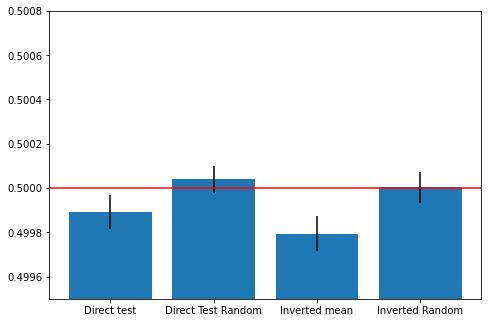

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Direct test', 'Direct Test Random', 'Inverted mean' , 'Inverted Random']
means = [results.direct_mean.mean(),
         results.random_direct_mean.mean(),
         results.inverted_mean.mean(),
         results.random_inverted_mean.mean()]
errors = [mean_confidence_interval(results.direct_mean),
         mean_confidence_interval(results.random_direct_mean),
         mean_confidence_interval(results.inverted_mean),
         mean_confidence_interval(results.random_inverted_mean)]
ax.bar(langs,means,yerr=errors)
ax.set_ylim(0.4995, 0.5008)
ax.axhline(y=0.5, color='r', linestyle='-')

plt.show()

In [36]:
results.window.unique()

array([2])

In [37]:
results.thr.unique().sort()

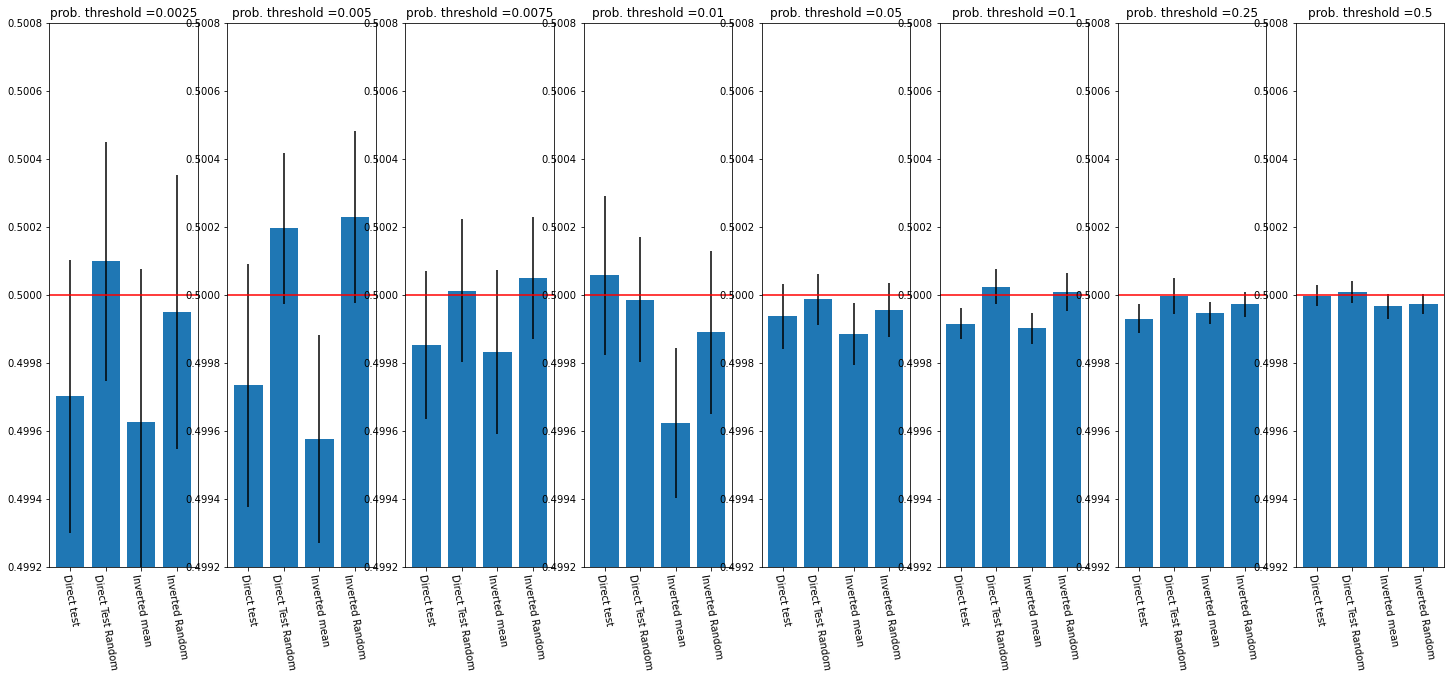

In [12]:
window = 2
f, axs = plt.subplots(1,8)
f.set_figwidth(25)
f.set_figheight(10)
sorted_ = results.thr.unique()
sorted_.sort()
for thr, ax in zip(sorted_, axs):

    results_tmp = results[(results.window==window)&(results.thr==thr)]
    langs = ['Direct test', 'Direct Test Random', 'Inverted mean' , 'Inverted Random']
    means = [results_tmp.direct_mean.mean(),
            results_tmp.random_direct_mean.mean(),
            results_tmp.inverted_mean.mean(),
            results_tmp.random_inverted_mean.mean()]
    errors = [mean_confidence_interval(results_tmp.direct_mean),
            mean_confidence_interval(results_tmp.random_direct_mean),
            mean_confidence_interval(results_tmp.inverted_mean),
            mean_confidence_interval(results_tmp.random_inverted_mean)]
    ax.bar(langs,means,yerr=errors)
    fig.autofmt_xdate()
    ax.set_title("prob. threshold =" +str(thr))
    ax.set_ylim(0.4992, 0.5008)
    ax.tick_params(axis='x', labelrotation=-80)
    ax.axhline(y=0.5, color='r', linestyle='-')


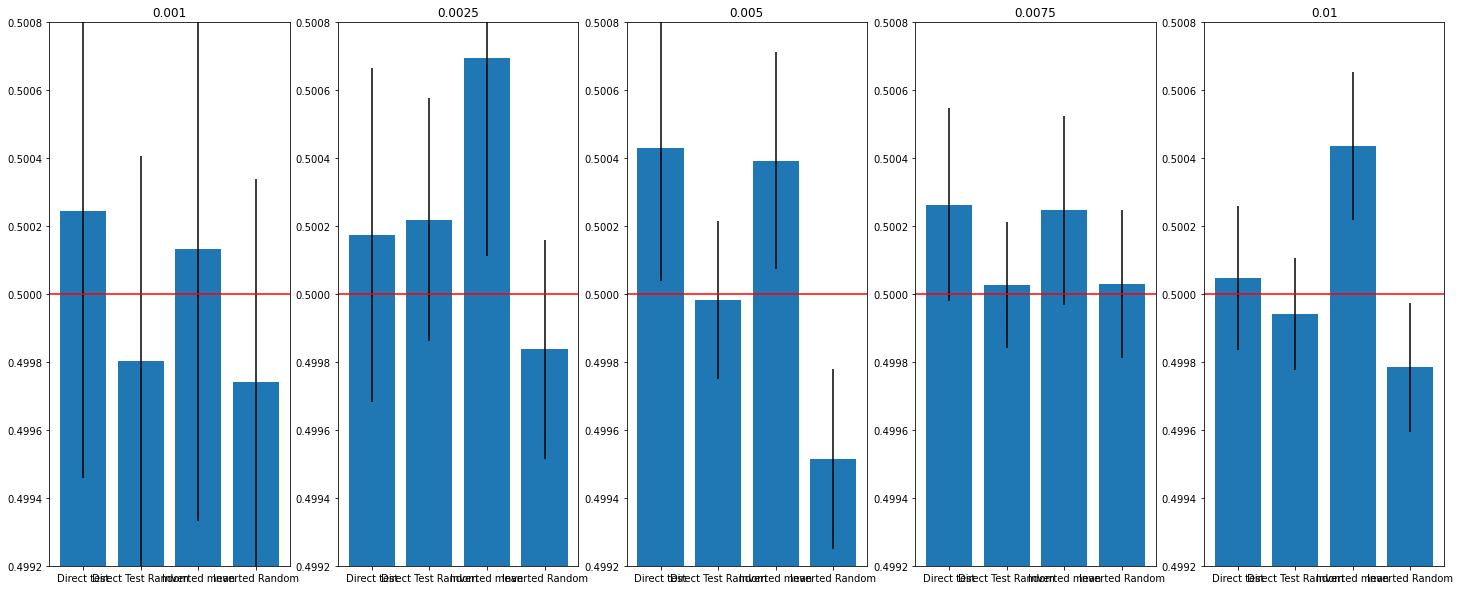

In [29]:

window = 3
f, axs = plt.subplots(1,5)
f.set_figwidth(25)
f.set_figheight(10)
sorted_ = results.thr.unique()
sorted_.sort()
for thr, ax in zip(sorted_, axs):

    results_tmp = results[(results.window==window)&(results.thr==thr)]
    langs = ['Direct test', 'Direct Test Random', 'Inverted mean' , 'Inverted Random']
    means = [results_tmp.direct_mean.mean(),
            results_tmp.random_direct_mean.mean(),
            results_tmp.inverted_mean.mean(),
            results_tmp.random_inverted_mean.mean()]
    errors = [mean_confidence_interval(results_tmp.direct_mean),
            mean_confidence_interval(results_tmp.random_direct_mean),
            mean_confidence_interval(results_tmp.inverted_mean),
            mean_confidence_interval(results_tmp.random_inverted_mean)]
    ax.bar(langs,means,yerr=errors)
    ax.set_title(thr)
    ax.set_ylim(0.4992, 0.5008)
    ax.axhline(y=0.5, color='r', linestyle='-')


In [10]:
results.direct_mean.mean()

0.5003085105775387

In [12]:
results.inverted_mean.mean()

0.5003928619899972

In [13]:
results.random_inverted_mean.mean()

0.49984293204069524

In [14]:
results.direct_mean.std()

0.0012493638645021626

In [11]:
results

,direct_mean,direct_counts,direct_nans,random_direct_mean,random_direct_counts,random_direct_nans,inverted_mean,inverted_counts,inverted_nans,random_inverted_mean,random_inverted_counts,random_inverted_nans,window,thr
0,0.500396,313197,3.999071,0.500439,312361,3.998671,0.499634,313971,1.574499,0.500606,312067,1.577302,2,0.010
1,0.500430,313421,2.816825,0.500418,314199,2.815712,0.500628,312328,2.755004,0.500405,313007,2.757782,2,0.010
2,0.500626,311300,4.647196,0.500954,313887,4.649125,0.500648,312987,0.928809,0.499787,312781,0.930415,2,0.010
3,0.500351,312969,3.069579,0.499574,313781,3.070116,0.501055,311975,2.509480,0.499929,312231,2.508777,2,0.010
4,0.501174,314178,2.725926,0.499938,312680,2.722560,0.500813,312638,2.855417,0.500488,312963,2.854468,2,0.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,0.498786,30900,3.387443,0.497907,31229,3.386788,0.503172,30959,2.191964,0.501660,31050,2.188019,3,0.001
316,0.502997,31284,1.949431,0.498436,31010,1.949145,0.497389,30828,3.653043,0.499252,31216,3.627883,3,0.001
317,0.499796,30970,2.737843,0.499309,31193,2.729875,0.500090,31166,2.852435,0.503592,31306,2.842810,3,0.001
318,0.502505,31785,2.836558,0.500451,31251,2.828389,0.499154,30922,2.748464,0.496254,31419,2.740444,3,0.001


In [4]:
with open('r1.pickle','rb') as file:
    results = pickle.load(file)

In [46]:
results1 = [x for x in results if type(x)==dict]

In [47]:
results1 = pd.DataFrame(results1)

In [48]:
results1

,mean,counts,window,thr
0,0.500235,314154,2,0.010
1,0.500480,313777,2,0.010
2,0.500163,312978,2,0.010
3,0.501219,313177,2,0.010
4,0.500871,312021,2,0.010
...,...,...,...,...
155,0.500234,31100,3,0.001
156,0.499413,31508,3,0.001
157,0.500532,31052,3,0.001
158,0.495916,31294,3,0.001


In [69]:
import scipy 

means = results1[(results1.window==2)&(results1.thr==0.01)]

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h
# print(means)
mean_confidence_interval(means)

(0.5004947108789995, 0.5003041563439701, 0.500685265414029)

In [78]:
np.nanmean(data.iloc[3:])

72916056.72138348

In [76]:
data.iloc[3:]

,mean,counts,window
thr,,,
0.0075,0.500459,234921.3750,2.0
0.0100,0.500495,313092.6875,2.0


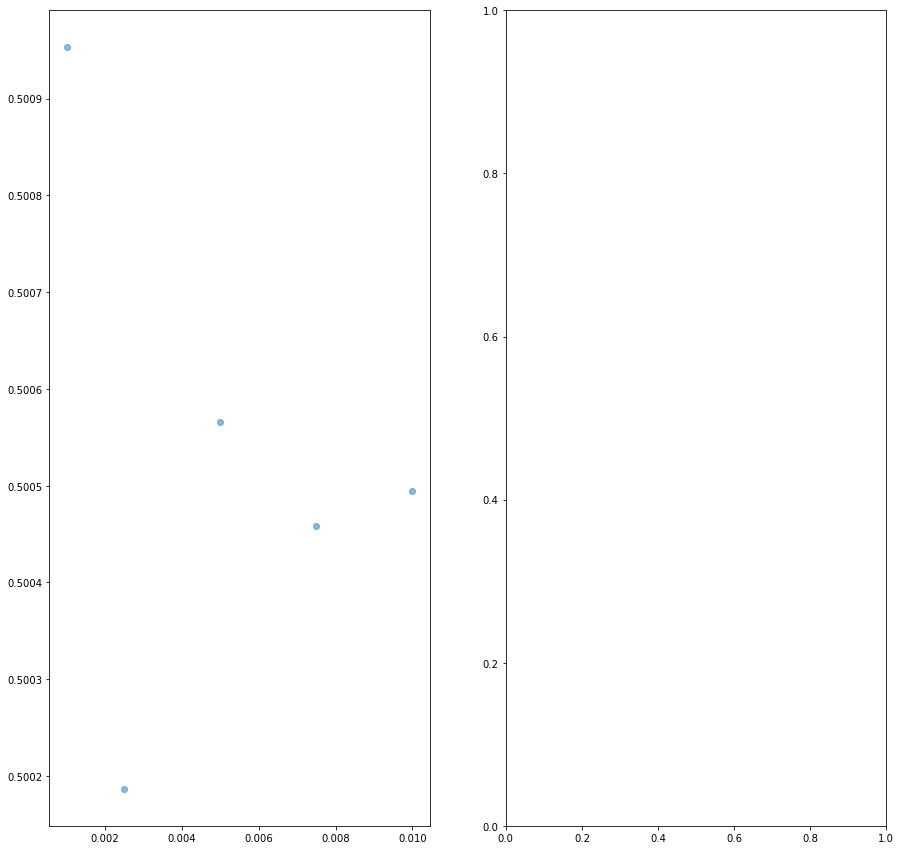

In [54]:
fig, axs = plt.subplots(1, 2,figsize=(15,15))
data = results1[(results1.window==2)].groupby('thr').mean()

axs[0].scatter(data.index, data['mean'], alpha=0.5)
ax.fill_between(q.index, (q['mean']-ci['mean']), (q['mean']+ci['mean']), color='b', alpha=.1)

In [32]:
def is_out(s):
    return True if s[0]>0.5 or s[1]<0.5 else False

results['ci'] = results.apply(lambda x: proportion_confint(int(x['mean']*x['counts']), x['counts']), axis=1)
results['ci_out'] = results.apply(lambda x: is_out(proportion_confint(int(x['mean']*x['counts']), x['counts'])), axis=1)

In [35]:
results[results.ci_out==True]

,mean,counts,window,thr,ci,ci_out
17,0.500568,3122247,2,0.100,"(0.5000134148847756, 0.5011226259217333)",True
203,0.501820,311391,3,0.010,"(0.5000631038129972, 0.5035754085396398)",True
279,0.502729,156902,3,0.005,"(0.5002538304825795, 0.50520180424483)",True
287,0.502516,156917,3,0.005,"(0.5000401937711982, 0.5049879421222996)",True


In [14]:
results = []
with tqdm(total=5*1) as pbar:
    for thr in [0.5, 0.25, 0.1, 0.05, 0.01,0.0075,0.005,0.0025]:
        for window in [1]:
            partial_results = Parallel(n_jobs=2, prefer="threads")(delayed(make_run)(thr, window) for i in range(32))
            results.append(partial_results)
            pbar.update(1)

  0%|          | 0/5 [00:00<?, ?it/s]

NameError: name 'make_run' is not defined

In [32]:
results_tmp = flatten(results)

In [34]:
pd.DataFrame(results_tmp).to_pickle('results_w1_2014.pickle')

In [35]:
results_w1 = pd.read_pickle('results_w1_2014.pickle')

In [38]:
results_w1

,direct_mean,direct_counts,direct_nans,random_direct_mean,random_direct_counts,random_direct_nans,inverted_mean,inverted_counts,inverted_nans,random_inverted_mean,random_inverted_counts,random_inverted_nans,window,thr
0,0.500125,15793258,0.866195,0.500129,15768395,0.867464,0.500162,15806360,1.089926,0.500115,15767133,1.090102,1,0.5000
1,0.500055,15818866,1.191304,0.500103,15767065,1.192638,0.499942,15798302,0.765129,0.500029,15769153,0.764911,1,0.5000
2,0.500091,15834164,0.746508,0.500076,15765859,0.748337,0.500101,15829326,1.210853,0.500128,15762777,1.209537,1,0.5000
3,0.500019,15796653,0.869255,0.500081,15767002,0.869536,0.500071,15809720,1.086072,0.500001,15768910,1.087982,1,0.5000
4,0.500042,15809648,0.843914,0.500088,15771007,0.844702,0.499980,15812507,1.111445,0.500075,15768514,1.112939,1,0.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,0.500634,79122,0.925052,0.499516,79090,0.922291,0.501431,79607,1.036077,0.500248,78845,1.035525,1,0.0025
252,0.499006,77799,1.017121,0.499751,78580,1.012280,0.500889,80205,0.946525,0.500620,78855,0.949020,1,0.0025
253,0.501444,78766,0.891476,0.499955,79059,0.890120,0.500840,78902,1.055030,0.499258,78631,1.063397,1,0.0025
254,0.499008,80094,1.005494,0.500322,78850,1.011224,0.499505,78428,0.956546,0.499643,78885,0.958598,1,0.0025


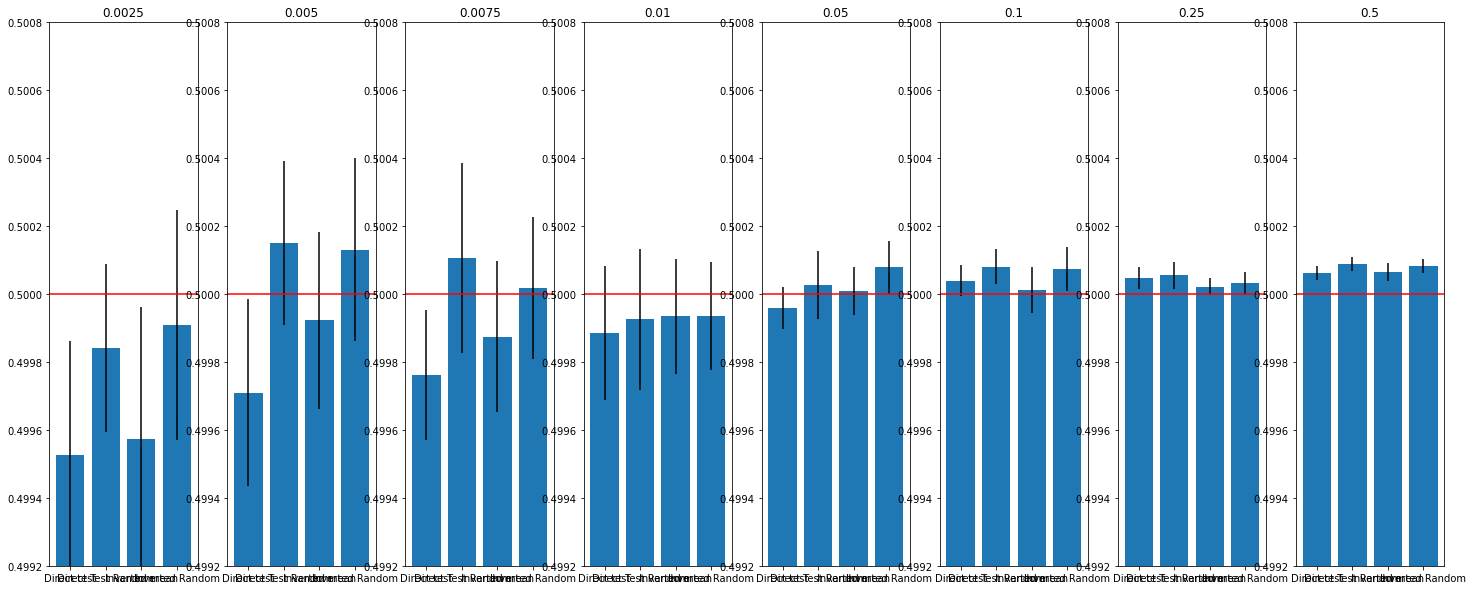

In [42]:
window = 1
f, axs = plt.subplots(1,8)
f.set_figwidth(25)
f.set_figheight(10)
sorted_ = results_w1.thr.unique()
sorted_.sort()
for thr, ax in zip(sorted_, axs):

    results_tmp = results_w1[(results_w1.window==window)&(results_w1.thr==thr)]
    langs = ['Direct test', 'Direct Test Random', 'Inverted mean' , 'Inverted Random']
    means = [results_tmp.direct_mean.mean(),
            results_tmp.random_direct_mean.mean(),
            results_tmp.inverted_mean.mean(),
            results_tmp.random_inverted_mean.mean()]
    errors = [mean_confidence_interval(results_tmp.direct_mean),
            mean_confidence_interval(results_tmp.random_direct_mean),
            mean_confidence_interval(results_tmp.inverted_mean),
            mean_confidence_interval(results_tmp.random_inverted_mean)]
    ax.bar(langs,means,yerr=errors)
    ax.set_title(thr)
    ax.set_ylim(0.4992, 0.5008)
    ax.axhline(y=0.5, color='r', linestyle='-')


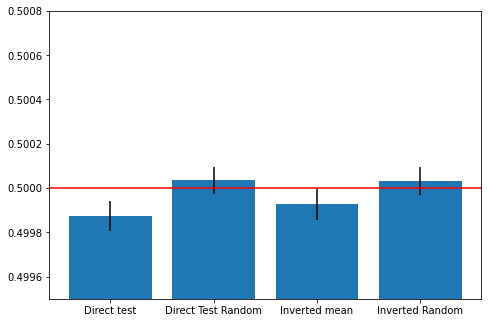

In [44]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Direct test', 'Direct Test Random', 'Inverted mean' , 'Inverted Random']
means = [results_w1.direct_mean.mean(),
         results_w1.random_direct_mean.mean(),
         results_w1.inverted_mean.mean(),
         results_w1.random_inverted_mean.mean()]
errors = [mean_confidence_interval(results_w1.direct_mean),
         mean_confidence_interval(results_w1.random_direct_mean),
         mean_confidence_interval(results_w1.inverted_mean),
         mean_confidence_interval(results_w1.random_inverted_mean)]
ax.bar(langs,means,yerr=errors)
ax.set_ylim(0.4995, 0.5008)
ax.axhline(y=0.5, color='r', linestyle='-')

plt.show()